In [1]:

#!pip install helical --use-pep517

#!pip install datasets --upgrade

In [2]:

from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import anndata as ad
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from scipy.sparse import lil_matrix
import torch.optim as optim
from helical.models.scgpt.model import scGPT, scGPTConfig
from helical.models.geneformer.model import Geneformer, GeneformerConfig
from copy import deepcopy
from torch.nn.functional import one_hot
import torch
print(torch.__version__)  # Should print a version like 2.0.1+cu118 or 2.1.0+cu121
print(torch.version.cuda)  # Should print the CUDA version (e.g., 11.8 or 12.1)
print(torch.cuda.is_available()) 

INFO:datasets:PyTorch version 2.5.1+cu118 available.
INFO:helical:Caduceus not available: If you want to use this model, ensure you have a CUDA GPU and have installed the optional helical[mamba-ssm] dependencies.


2.5.1+cu118
11.8
True


In [3]:
from datasets import load_dataset
ds = load_dataset("helical-ai/yolksac_human",trust_remote_code=True, split="train[:65%]",download_mode="reuse_cache_if_exists")

Generating test split: 100%|██████████| 6336/6336 [00:03<00:00, 1710.84 examples/s]


In [4]:
observation_columns = [obs for obs in list(ds.features.keys()) if not obs == 'raw_counts']
obs_data = pd.DataFrame(ds.select_columns(observation_columns).data.to_pandas(),columns=observation_columns)
lil = lil_matrix((len(ds),ds[0]['size']))
lil.data = np.array(ds['raw_counts'],dtype="object")
lil.rows = np.array(ds['rows'],dtype="object")
adata = ad.AnnData(lil.tocsr(),obs=obs_data)
adata.var_names = ds.features['raw_counts'].id.split(",")
adata.var['gene_name'] = adata.var_names.str.upper()

In [5]:
# get labels: the celltype
num_types = adata.obs["LVL1"].unique().shape[0]
id2type = dict(enumerate(adata.obs["LVL1"].astype("category").cat.categories))

celltypes_labels = np.array(adata.obs["LVL1"].tolist())

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
scgpt_config = scGPTConfig(batch_size=50, device=device)
scgpt = scGPT(configurer = scgpt_config)
#print(load_model(scgpt_config)[1])


def knockout_genes(data,model,genes):
  """ Generate embeddings for the original dataset and modified dataset using
  the selected model. The modified dataset has gene expressions set to 0 for
  all genes present in the genes list.

  Inputs:
      data (anndata): dataset that is being considered
      model ()
  """
  # generate embeddings on original data
  original_data = data.copy()
  new_data1 = model.process_data(adata = original_data, gene_names = "gene_name")
  
  x_model = model.get_embeddings(new_data1)
  
  gene_indices = [data.var.index.get_loc(gene) for gene in genes if gene in data.var.index]
  # update data in a vectorised way all at once to reduce memory spike
  data.X[:,gene_indices] = 0 
  
  new_data = model.process_data(adata = data, gene_names = "gene_name")
 # print(data.X[0:50])
  # check which genes are not chosen by the model
  print([i for i in range(100) if data.var["gene_name"][i] not in new_data.vocab])
  
  x_model_dropped = model.get_embeddings(new_data)
  
  return x_model, x_model_dropped
#genes_to_knockout = ['A1BG', 'A1BG-AS1', 'A1CF', 'A2M']
genes_to_knockout = list(adata.var_names[0:40])

x_modelt, x_model_droppedt = knockout_genes(adata,scgpt,genes_to_knockout)


INFO:helical.utils.downloader:File: 'C:\Users\tomjo\.cache\helical\models\scgpt/scGPT_CP/vocab.json' exists already. File is not overwritten and nothing is downloaded.
INFO:helical.utils.downloader:File saved to: 'C:\Users\tomjo\.cache\helical\models\scgpt/scGPT_CP/vocab.json'
INFO:helical.utils.downloader:File: 'C:\Users\tomjo\.cache\helical\models\scgpt/scGPT_CP/best_model.pt' exists already. File is not overwritten and nothing is downloaded.
INFO:helical.utils.downloader:File saved to: 'C:\Users\tomjo\.cache\helical\models\scgpt/scGPT_CP/best_model.pt'
INFO:helical.models.scgpt.model:Model finished initializing.
INFO:helical.models.scgpt.model:Filtering out 11163 genes to a total of 26155 genes with an id in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Inference started:
Embedding cells: 100%|██████████| 330/330 [03:04<00:00,  1.79it/s]
INFO:helical.models.scgpt.model:Filtering out 11163 genes to a total of 26155 genes with an id in the scGPT vocabulary.
INFO:helical.models

[15, 23, 33, 34, 39, 82]


Embedding cells: 100%|██████████| 330/330 [03:31<00:00,  1.56it/s]


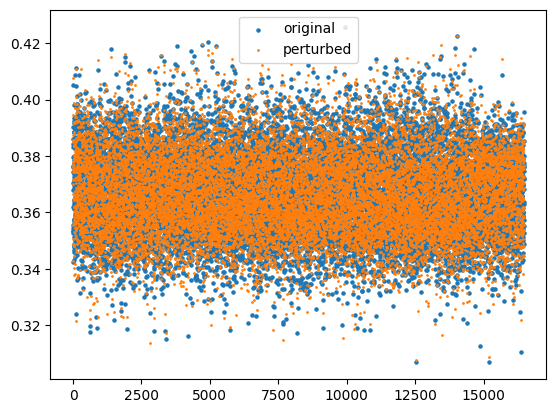

[False False False ... False False False]


In [7]:
import matplotlib.pyplot as plt
i=200
plt.figure()
plt.scatter(list(range(len(x_modelt[:,0]))), np.sum(x_modelt,axis=1), label="original",s=5)
plt.scatter(list(range(len(x_modelt[:,0]))), np.sum(x_model_droppedt,axis=1), label="perturbed",s=1)
plt.legend()
plt.show()
error = 0
index = 0
x = np.sum(x_modelt,axis=1)
y = np.sum(x_model_droppedt,axis=1)
for i in range(len(x_modelt[:,0])):
    squared_error = (x[i]-y[i])**2
    if squared_error > error:
        index=i

print(x_modelt[:,0]==x_model_droppedt[:,0])

In this cell example almost all of the genes that have been knocked out are present, so the fact that this example has changed by the largest amount in importance is to be expected.

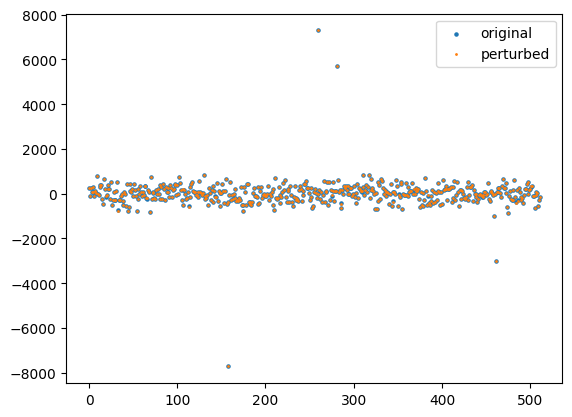

In [8]:
import matplotlib.pyplot as plt
i=200
plt.figure()
plt.scatter(list(range(len(x_modelt[0]))), np.sum(x_modelt,axis=0), label="original",s=5)
plt.scatter(list(range(len(x_modelt[0]))), np.sum(x_model_droppedt,axis=0), label="perturbed",s=1)
plt.legend()
plt.show()


In [9]:

# for all embeddings find the MSE between orginal and unperturbed data
#for i in range(len(x_model[0])):
mse = 0
for i,j in zip(x_modelt,x_model_droppedt):
  mse += (i-j)**2
# find which embedding depends the most on the genes that have been knocked out
print(np.argmax(mse))
mse = 0
for i,j in zip(x_modelt.T,x_model_droppedt.T):
  mse += (i-j)**2
# find which genes now has been reduced in importance by the largest amount
print(np.argmax(mse))


281
237


In [10]:
num_types = adata.obs["LVL1"].unique().shape[0]
id2type = dict(enumerate(adata.obs["LVL1"].astype("category").cat.categories))
celltypes_labels = np.array(adata.obs["LVL1"].tolist())


In [11]:
num_types = adata.obs["LVL1"].unique().shape[0]
id2type = dict(enumerate(adata.obs["LVL1"].astype("category").cat.categories))
celltypes_labels = np.array(adata.obs["LVL1"].tolist())
labels = adata.obs["LVL1"].unique()
print(labels)
for i in range(6):
    #print(f"{labels[i]} has {len(adata[adata.obs["LVL1"]==labels[i]])} datapoints")
    print(labels[i],len(adata[adata.obs["LVL1"]==labels[i]]))

lymphoid_data = adata[adata.obs["LVL1"]==labels[5]]
# store frequency of genes in a list where index corresponds to gene_index shown in row
gene_list = np.zeros(len(adata.var))
for x in lymphoid_data.obs['rows']:
    for gene in x:
        gene_list[gene] += 1

print(np.where(gene_list==29.0)[0])
knockout = np.where(gene_list==29.0)[0]
x_model, x_model_dropped = knockout_genes(adata,scgpt,knockout)

['STROMA' 'ERYTHROID' 'MYELOID' 'MK' 'PROGENITOR' 'LYMPHOID']
STROMA 7824
ERYTHROID 3468
MYELOID 4888
MK 118
PROGENITOR 147
LYMPHOID 29
[ 5881  5883  9558  9788  9802  9902 10281 10975 11895 11968 12217 12525
 12538 13775 14048 14731 14739 14740 14742 14743 14824 14883 14994 15725
 16226 16227 16300 16379 16405 16720 16962 17219 17263 17264 17510 17653
 17682 17695 17858 17876 19349 22522 22524 22525 22526 22527 22531 22532
 22533 22723 22728 22829 23015 23037 23415 23682 23907 23995 24184 24328
 24484 24494 25142 25568 25613 25688 25941 25944 31320 31321 31323 31324
 31325 31326 31327 31328 31329 31331 31332 31333 31334 31335 31338 31340
 31341 31344 31346 31347 31348 31349 31350 31351 31352 31355 31356 31357
 31358 31361 31362 31363 31364 31367 31368 31369 31370 31371 31372 31374
 31375 31376 31377 31378 31398 31399 31400 31401 31402 31403 31404 31405
 31406 31407 31409 31411 31412 31413 31414 31415 31416 31417 31419 31421
 31422 31423 31426 31427 31441 31442 31443 31444 31968 32020 

INFO:helical.models.scgpt.model:Filtering out 11163 genes to a total of 26155 genes with an id in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Inference started:
Embedding cells: 100%|██████████| 330/330 [03:30<00:00,  1.57it/s]
INFO:helical.models.scgpt.model:Filtering out 11163 genes to a total of 26155 genes with an id in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Inference started:


[15, 23, 33, 34, 39, 82]


Embedding cells: 100%|██████████| 330/330 [03:38<00:00,  1.51it/s]


Neural network:

In [12]:
y = celltypes_labels
num_classes = num_types

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_encoded = one_hot(torch.tensor(y_encoded),num_classes).float()

In [13]:
# embedding dimension is 512 (no nn.Dropout)
input_shape = 512
def build_model(hidden_layer_sizes,activation_function):
    classification_model = nn.Sequential(
    nn.Linear(input_shape, hidden_layer_sizes[0]),
    activation_function,
    nn.Linear(hidden_layer_sizes[0], hidden_layer_sizes[1]),
    activation_function,
    nn.Linear(hidden_layer_sizes[1], num_classes)
    )
    return classification_model

classification_model = build_model([128,32],nn.ReLU())



In [14]:
def train_model(model,
                X_train,
                y_train,  
                X_val, 
                y_val, 
                optimizer = optim.Adam, 
                loss_fn = nn.CrossEntropyLoss(),
                num_epochs = 50, 
                batch = 64,
                plotting = True):    

    # Create DataLoader for batching
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)

    val_dataset = TensorDataset(X_val, y_val)
    # Do not shuffle as no need, and to keep consistency in val set between epochs
    val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)

    # Ensure model is in training mode
    model.train()
    # Record losses per epoch for checking overfitting
    global_val_losses = []
    global_train_losses = []
    for epoch in range(num_epochs):
        for batch_X, batch_y in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(batch_X)
            
            # Compute loss
            loss = loss_fn(outputs, batch_y)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            # Clear gradients for next batch
            optimizer.zero_grad()
        
        # Validation step
        model.eval()
        with torch.no_grad():
            val_losses = []
            for val_X, val_y in val_loader:
                val_outputs = model(val_X)
                val_loss = loss_fn(val_outputs, val_y)
                val_losses.append(val_loss.item())
            if plotting:
                train_losses = []
                for train_X, train_y in train_loader:
                    train_outputs = model(train_X)
                    train_loss = loss_fn(train_outputs, train_y)
                    train_losses.append(train_loss.item())
            global_val_losses.append(sum(val_losses)/len(val_losses))
            global_train_losses.append(sum(train_losses)/len(train_losses))
            print(f"Epoch {epoch+1}, Validation Loss: {sum(val_losses)/len(val_losses)}")
        
        # Set back to training mode for next epoch
        model.train()
    # Compare train and val losses per epoch
    if plotting:
        plt.plot(range(num_epochs),global_val_losses, label = "val loss")  
        plt.plot(range(num_epochs),global_train_losses, label = "train loss")  
        plt.legend()
        plt.show()

    model.eval()   
    return model

In [15]:
def train_mode_MSE(model,
                X_train,
                y_train,  
                X_val, 
                y_val, 
                optimizer = optim.Adam, 
                loss_fn = nn.CrossEntropyLoss(),
                num_epochs = 50, 
                batch = 64,
                plotting = True):    

    # Create DataLoader for batching
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)

    val_dataset = TensorDataset(X_val, y_val)
    # Do not shuffle as no need, and to keep consistency in val set between epochs
    val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)

    # Ensure model is in training mode
    model.train()
    # Record losses per epoch for checking overfitting
    global_val_losses = []
    global_train_losses = []
    for epoch in range(num_epochs):
        for batch_X, batch_y in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(batch_X)
            
            # Compute loss
            loss = loss_fn(outputs, batch_y)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            # Clear gradients for next batch
            optimizer.zero_grad()
        
        # Validation step
        model.eval()
        with torch.no_grad():
            val_losses = []
            for val_X, val_y in val_loader:
                val_outputs = model(val_X)
                val_loss = loss_fn(val_outputs, val_y)
                val_losses.append(val_loss.item())
            
            #train_losses = []
            #for train_X, train_y in train_loader:
            #    train_outputs = model(train_X)
            #    train_loss = loss_fn(train_outputs, train_y)
            #    train_losses.append(train_loss.item())
            global_val_losses.append(sum(val_losses)/len(val_losses))
           # global_train_losses.append(sum(train_losses)/len(train_losses))
            print(f"Epoch {epoch+1}, Validation Loss: {sum(val_losses)/len(val_losses)}")
        
        # Set back to training mode for next epoch
        model.train()
    # Compare train and val losses per epoch
    if plotting:
        plt.plot(range(num_epochs),global_val_losses, label = "val loss")  
        plt.plot(range(num_epochs),global_train_losses, label = "train loss")  
        plt.legend()
        plt.show()

    model.eval()   
    return model, global_train_losses, global_val_losses

Sequential(
  (0): Linear(in_features=512, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=6, bias=True)
)
Epoch 1, Validation Loss: 0.08749755310754363
Epoch 2, Validation Loss: 0.05972893134905742
Epoch 3, Validation Loss: 0.05396768502676143
Epoch 4, Validation Loss: 0.04671509945406937
Epoch 5, Validation Loss: 0.042946185218170285
Epoch 6, Validation Loss: 0.04102804710587057
Epoch 7, Validation Loss: 0.03929797423860201
Epoch 8, Validation Loss: 0.044179409473704606
Epoch 9, Validation Loss: 0.03805624227075336
Epoch 10, Validation Loss: 0.0362129743085601
Epoch 11, Validation Loss: 0.03749516339471134
Epoch 12, Validation Loss: 0.04006870796617407
Epoch 13, Validation Loss: 0.03401044946020612
Epoch 14, Validation Loss: 0.03369383924963096
Epoch 15, Validation Loss: 0.03255532607615281
Epoch 16, Validation Loss: 0.03883545007556677
Epoch 17, Validation Loss: 0.031792642

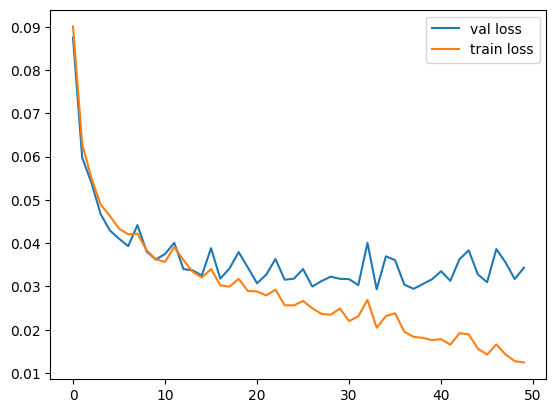

In [16]:
X_train, X_val, y_train, y_val = train_test_split(x_model_dropped, y_encoded, test_size=0.1, random_state=42)


classification_model = build_model([128,32],nn.ReLU())
new_model = deepcopy(classification_model)
print(new_model)
new_model = train_model(new_model, 
                               torch.from_numpy(X_train), 
                               y_train, 
                               torch.from_numpy(X_val), 
                               y_val,
                               optim.Adam(new_model.parameters(), lr=0.001),
                               nn.CrossEntropyLoss())

Sequential(
  (0): Linear(in_features=512, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=6, bias=True)
)
Epoch 1, Validation Loss: 0.09650608682288574
Epoch 2, Validation Loss: 0.07655153271312323
Epoch 3, Validation Loss: 0.06038317451468454
Epoch 4, Validation Loss: 0.052188876192443646
Epoch 5, Validation Loss: 0.05159590119281067
Epoch 6, Validation Loss: 0.04508457246881265
Epoch 7, Validation Loss: 0.04433782294822427
Epoch 8, Validation Loss: 0.04122536192433192
Epoch 9, Validation Loss: 0.03950814048473079
Epoch 10, Validation Loss: 0.03932869074364694
Epoch 11, Validation Loss: 0.04119538456703035
Epoch 12, Validation Loss: 0.03731790152736581
Epoch 13, Validation Loss: 0.04372235579201235
Epoch 14, Validation Loss: 0.03652429116818194
Epoch 15, Validation Loss: 0.03807734926410306
Epoch 16, Validation Loss: 0.043159069368042625
Epoch 17, Validation Loss: 0.03398603

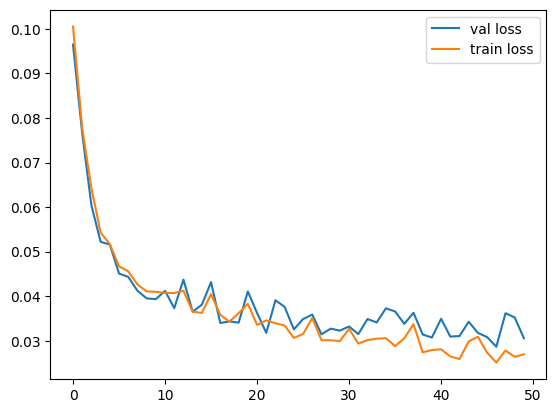

In [17]:
X_train, X_val, y_train, y_val = train_test_split(x_model_dropped, y_encoded, test_size=0.1, random_state=42)


classification_model = build_model([128,32],nn.ReLU())
new_model = deepcopy(classification_model)
print(new_model)
new_model = train_model(new_model, 
                               torch.from_numpy(X_train), 
                               y_train, 
                               torch.from_numpy(X_val), 
                               y_val,
                               optim.Adam(new_model.parameters(), lr=0.001, weight_decay=1e-4),
                               nn.CrossEntropyLoss())

This large difference between the validation and training loss implies the model is overfitting 

In [20]:
from sklearn.model_selection import ParameterGrid, GridSearchCV, KFold
def perform_hyperparameter_search(X_train, y_train, X_val, y_val):
    # Ensure to add whatever inputs you deem necessary to this function
    """
    Performs a hyper-parameter for fine-tuning the regressor implemented
    in the Regressor class.

    Arguments:
        Add whatever inputs you need.

    Returns:
        The function should return your optimised hyper-parameters.

    """

    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    parameter_grid = {
      
        'learning_rate': [0.01,0.001],
        'hidden_layer_size': [[256, 64],[128, 32],[128, 64]],
        'activation_fn': [torch.nn.ReLU(),torch.nn.Tanh()],
        'nb_epoch': [50]
    }
    best_loss = float('inf')
    best_params = None
    grid = ParameterGrid(parameter_grid)

   

    for parameters in grid:
        print(f"Testing parameters: {parameters}")
       
        if True:
            
            classification_model = build_model(parameters['hidden_layer_size'],parameters['activation_fn'])
            print(classification_model)
          
            classification_model, list_of_MSE_per_epoch, list_of_val = train_mode_MSE(classification_model, 
                torch.from_numpy(X_train), 
                y_train, 
                torch.from_numpy(X_val), 
                y_val,
                optim.Adam(classification_model.parameters(), lr=parameters['learning_rate'],weight_decay=1e-4),
                nn.CrossEntropyLoss(),
                num_epochs = parameters['nb_epoch'],
                plotting = False)

            min_loss = np.min(list_of_val)
            print(min_loss)
        # Update the best model if this one performs better
        if min_loss < best_loss:
            best_loss = min_loss
            best_params = parameters
            

    print("Best Parameters:", best_params)
    print("Lowest loss:", best_loss)
    return best_params


In [ ]:
print(perform_hyperparameter_search(X_train, y_train, X_val, y_val))

Testing parameters: {'activation_fn': ReLU(), 'hidden_layer_size': [256, 64], 'learning_rate': 0.01, 'nb_epoch': 50}
Sequential(
  (0): Linear(in_features=512, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=6, bias=True)
)
Epoch 1, Validation Loss: 0.07329926747255601
Epoch 2, Validation Loss: 0.0545164429797576
Epoch 3, Validation Loss: 0.05344964019381083
Epoch 4, Validation Loss: 0.05337761016562581
Epoch 5, Validation Loss: 0.05473016820346507
Epoch 6, Validation Loss: 0.06840627173928973
Epoch 7, Validation Loss: 0.05103522954651943
Epoch 8, Validation Loss: 0.0419146194248102
Epoch 9, Validation Loss: 0.03889127903116437
Epoch 10, Validation Loss: 0.06022220547311008
Epoch 11, Validation Loss: 0.03845556691074027
Epoch 12, Validation Loss: 0.03636659163301094
Epoch 13, Validation Loss: 0.04524626573905922
Epoch 14, Validation Loss: 0.037735770689323545
Epoch 15, Validat

Update model parameters to the optimal ones found by the hyperparameter search:

Epoch 1, Validation Loss: 0.07540105007445583
Epoch 2, Validation Loss: 0.055063333039960034
Epoch 3, Validation Loss: 0.049163095509776704
Epoch 4, Validation Loss: 0.04453455959446728
Epoch 5, Validation Loss: 0.05228027070944126
Epoch 6, Validation Loss: 0.05024662094477277
Epoch 7, Validation Loss: 0.041585534291628465
Epoch 8, Validation Loss: 0.04474147271293287
Epoch 9, Validation Loss: 0.04237968229258863
Epoch 10, Validation Loss: 0.04373132720446357
Epoch 11, Validation Loss: 0.039201204145613774
Epoch 12, Validation Loss: 0.044795886147767305
Epoch 13, Validation Loss: 0.03959098035612932
Epoch 14, Validation Loss: 0.0405817264243244
Epoch 15, Validation Loss: 0.044854088372980744
Epoch 16, Validation Loss: 0.040268776015951656
Epoch 17, Validation Loss: 0.0354813926298028
Epoch 18, Validation Loss: 0.044705419783265546
Epoch 19, Validation Loss: 0.03431914010658287
Epoch 20, Validation Loss: 0.04042016308700953
Epoch 21, Validation Loss: 0.03394674190069334
Epoch 22, Valida

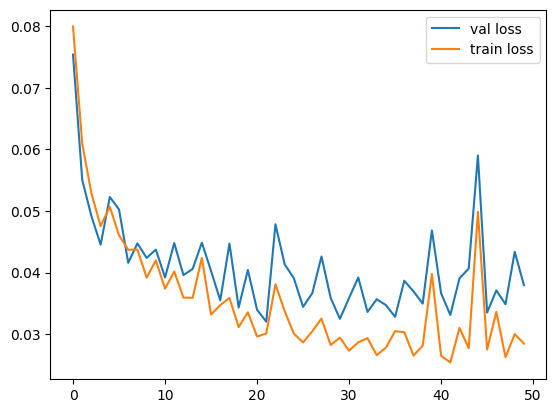

In [ ]:

X_train, X_val, y_train, y_val = train_test_split(x_model_dropped, y_encoded, test_size=0.1, random_state=42)
classification_model = build_model([128,64],nn.Tanh())
new_model = deepcopy(classification_model)
# dont need val set as this is our final model, so train on whole train set
new_model = train_model(new_model, 
                               torch.from_numpy(X_train), 
                               y_train, 
                               torch.from_numpy(X_val), 
                               y_val,
                               optim.Adam(new_model.parameters(), lr=0.001, weight_decay=1e-4),
                               nn.CrossEntropyLoss())

In [ ]:
def get_evaluations(name_data_set, y_true, y_pred) -> dict:
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average='macro')
  f1 = f1_score(y_true, y_pred, average='macro')
  recall = recall_score(y_true, y_pred, average='macro')
  precision_l = precision_score(y_true, y_pred, average=None, labels=['ERYTHROID', 'STROMA', 'MYELOID', 'LYMPHOID', 'PROGENITOR', 'MK'])[3]
  f1_l = f1_score(y_true, y_pred, average=None, labels=['ERYTHROID', 'STROMA', 'MYELOID', 'LYMPHOID', 'PROGENITOR', 'MK'])[3]
  recall_l = recall_score(y_true, y_pred, average=None, labels=['ERYTHROID', 'STROMA', 'MYELOID', 'LYMPHOID', 'PROGENITOR', 'MK'])[3]
  print(f"{name_data_set} accuracy: {(accuracy*100):.1f}%")
  print(f"{name_data_set} precision: {(precision*100):.1f}%")
  print(f"{name_data_set} f1: {(f1*100):.1f}%")
  print(f"{name_data_set} recall: {(recall*100):.1f}%")
  print(f"Lymphoid precision: {(precision_l*100):.1f}%")
  print(f"Lymphoid f1: {(f1_l*100):.1f}%")
  print(f"Lymphoid recall: {(recall_l*100):.1f}%")
  return {
      "accuracy": accuracy,
      "precision": precision,
      "f1": f1,
      "recall": recall,
  }

In [ ]:
ds = load_dataset("helical-ai/yolksac_human",trust_remote_code=True, split="train[70%:]",download_mode="reuse_cache_if_exists")

Generating test split: 100%|██████████| 6336/6336 [00:03<00:00, 1654.79 examples/s]


In [ ]:
observation_columns = [obs for obs in list(ds.features.keys()) if not obs == 'raw_counts']
obs_data = pd.DataFrame(ds.select_columns(observation_columns).data.to_pandas(),columns=observation_columns)
lil = lil_matrix((len(ds),ds[0]['size']))
lil.data = np.array(ds['raw_counts'],dtype="object")
lil.rows = np.array(ds['rows'],dtype="object")
adata_unseen = ad.AnnData(lil.tocsr(),obs=obs_data)
adata_unseen.var_names = ds.features['raw_counts'].id.split(",")
adata_unseen.var['gene_name'] = adata_unseen.var_names.str.upper()

In [ ]:
data_unseen = scgpt.process_data(adata_unseen, gene_names="gene_name")
x_unseen = scgpt.get_embeddings(data_unseen)
predictions_nn_unseen = new_model(torch.Tensor(x_unseen))

INFO:helical.models.scgpt.model:Filtering out 11163 genes to a total of 26155 genes with an id in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Inference started:
Embedding cells: 100%|██████████| 153/153 [01:15<00:00,  2.02it/s]


In [ ]:
y_true_unseen = np.array(adata_unseen.obs["LVL1"].tolist())
y_pred_unseen = [id2type[prediction] for prediction in np.array(torch.argmax(predictions_nn_unseen, dim=1))]

print(precision_score(y_true_unseen, y_pred_unseen, average=None,labels=['ERYTHROID', 'STROMA', 'MYELOID', 'LYMPHOID', 'PROGENITOR', 'MK']))
results = get_evaluations("Evaluation set", y_true_unseen, y_pred_unseen)

[0.99735537 0.99852768 0.97687327 0.59375    0.6        0.89795918]
Evaluation set accuracy: 99.2%
Evaluation set precision: 84.4%
Evaluation set f1: 85.6%
Evaluation set recall: 88.0%
Lymphoid precision: 59.4%
Lymphoid f1: 70.4%
Lymphoid recall: 86.4%


['ERYTHROID' 'LYMPHOID' 'MK' 'MYELOID' 'PROGENITOR' 'STROMA']


<Axes: >

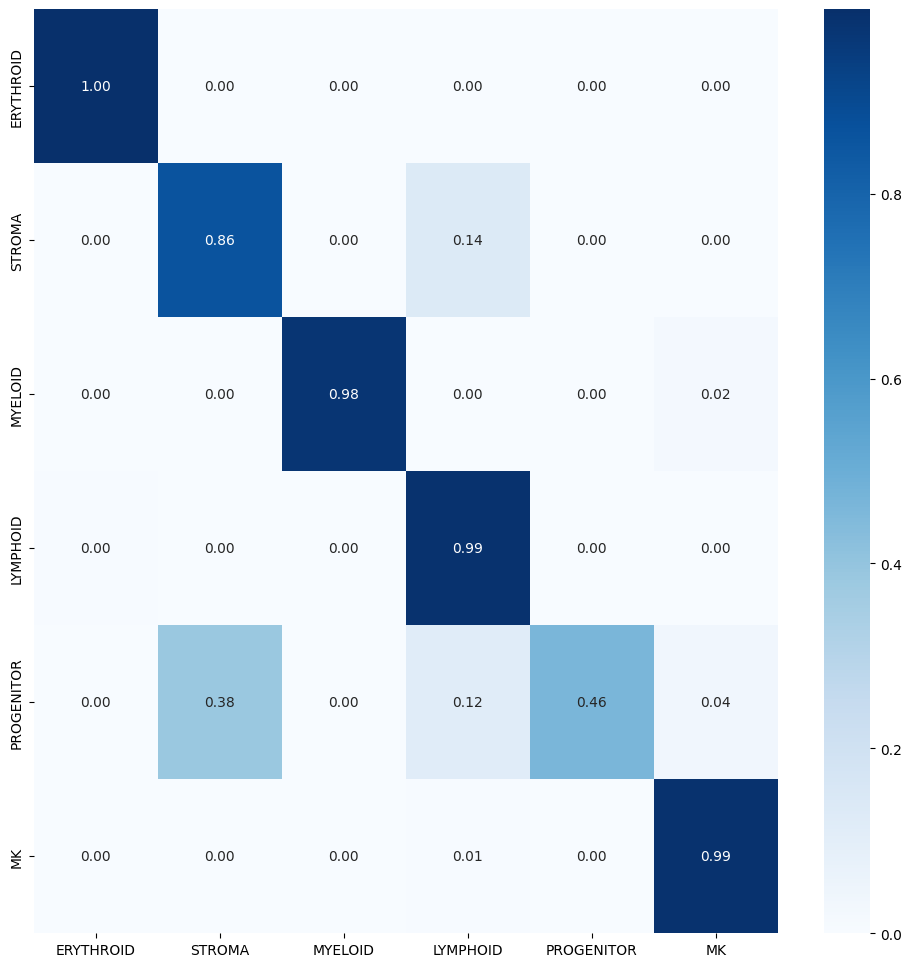

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
print(np.unique(y_true_unseen))
set_predicted_cell_types = list(adata_unseen.obs["LVL1"].unique())
for i in set(y_pred_unseen):
    if i not in set_predicted_cell_types:
        set_predicted_cell_types.remove(i)
# ground truth on y axis, predicted on x axis
cm = confusion_matrix(y_true_unseen, y_pred_unseen)
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
cm = pd.DataFrame(cm, index=set_predicted_cell_types[:cm.shape[0]], columns=set_predicted_cell_types[:cm.shape[1]])
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues")

High recall, lower precision on Lymphoid cells

In [ ]:
num_types = adata.obs["LVL1"].unique().shape[0]
id2type = dict(enumerate(adata.obs["LVL1"].astype("category").cat.categories))
celltypes_labels = np.array(adata.obs["LVL1"].tolist())
labels = adata.obs["LVL1"].unique()
print(labels)
for i in range(6):
    #print(f"{labels[i]} has {len(adata[adata.obs["LVL1"]==labels[i]])} datapoints")
    print(labels[i],len(adata[adata.obs["LVL1"]==labels[i]]))

lymphoid_data = adata[adata.obs["LVL1"]==labels[5]]
# store frequency of genes in a list where index corresponds to gene_index shown in row
gene_list = np.zeros(len(adata.var))
for x in lymphoid_data.obs['rows']:
    for gene in x:
        gene_list[gene] += 1

print(np.where(gene_list==29.0)[0])
knockout = np.where(gene_list==29.0)[0]



['STROMA' 'ERYTHROID' 'MYELOID' 'MK' 'PROGENITOR' 'LYMPHOID']
STROMA 7824
ERYTHROID 3468
MYELOID 4888
MK 118
PROGENITOR 147
LYMPHOID 29
[ 5881  5883  9558  9788  9802  9902 10281 10975 11895 11968 12217 12525
 12538 13775 14048 14731 14739 14740 14742 14743 14824 14883 14994 15725
 16226 16227 16300 16379 16405 16720 16962 17219 17263 17264 17510 17653
 17682 17695 17858 17876 19349 22522 22524 22525 22526 22527 22531 22532
 22533 22723 22728 22829 23015 23037 23415 23682 23907 23995 24184 24328
 24484 24494 25142 25568 25613 25688 25941 25944 31320 31321 31323 31324
 31325 31326 31327 31328 31329 31331 31332 31333 31334 31335 31338 31340
 31341 31344 31346 31347 31348 31349 31350 31351 31352 31355 31356 31357
 31358 31361 31362 31363 31364 31367 31368 31369 31370 31371 31372 31374
 31375 31376 31377 31378 31398 31399 31400 31401 31402 31403 31404 31405
 31406 31407 31409 31411 31412 31413 31414 31415 31416 31417 31419 31421
 31422 31423 31426 31427 31441 31442 31443 31444 31968 32020 

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
scgpt_config = scGPTConfig(batch_size=50, device=device)
scgpt = scGPT(configurer = scgpt_config)
#print(load_model(scgpt_config)[1])


def knockout_genes(data,model,genes):
  """ Generate embeddings for the original dataset and modified dataset using
  the selected model. The modified dataset has gene expressions set to 0 for
  all genes present in the genes list.

  Inputs:
      data (anndata): dataset that is being considered
      model ()
  """
  # knockout genes using batching to reduce explosion in RAM usage
  batch_size = 100
  original_data = data.copy()
  #print(len(genes))
  
  #gene_indices = [data.var.index.get_loc(gene) for gene in genes if gene in data.var.index]
  # update data in a vectorised way all at once to reduce memory spike
  data.X[:,genes] = 0 
  
  new_data = model.process_data(adata = data, gene_names="gene_name")
  print([i for i in knockout if data.var["gene_name"][i] not in new_data.vocab])
  
  
  x_model_dropped = model.get_embeddings(new_data)
  # generate embeddings on original data
  new_data1 = model.process_data(adata = original_data, gene_names = "gene_name")
  x_model = model.get_embeddings(new_data1)
  return x_model, x_model_dropped
#genes_to_knockout = ['A1BG', 'A1BG-AS1', 'A1CF', 'A2M']
#genes_to_knockout = list(adata.var_names[0:40])

x_model, x_model_dropped = knockout_genes(adata,scgpt,knockout)



INFO:helical.utils.downloader:File: 'C:\Users\tomjo\.cache\helical\models\scgpt/scGPT_CP/vocab.json' exists already. File is not overwritten and nothing is downloaded.
INFO:helical.utils.downloader:File saved to: 'C:\Users\tomjo\.cache\helical\models\scgpt/scGPT_CP/vocab.json'
INFO:helical.utils.downloader:File: 'C:\Users\tomjo\.cache\helical\models\scgpt/scGPT_CP/best_model.pt' exists already. File is not overwritten and nothing is downloaded.
INFO:helical.utils.downloader:File saved to: 'C:\Users\tomjo\.cache\helical\models\scgpt/scGPT_CP/best_model.pt'
INFO:helical.models.scgpt.model:Model finished initializing.
INFO:helical.models.scgpt.model:Filtering out 11163 genes to a total of 26155 genes with an id in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Inference started:


[17219, 17263, 17264]


Embedding cells: 100%|██████████| 330/330 [03:28<00:00,  1.59it/s]
INFO:helical.models.scgpt.model:Filtering out 11163 genes to a total of 26155 genes with an id in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Inference started:
Embedding cells: 100%|██████████| 330/330 [09:02<00:00,  1.64s/it]


Evaluation set accuracy: 99.2%
Evaluation set precision: 86.5%
Evaluation set f1: 86.6%
Evaluation set recall: 88.0%
Lymphoid precision: 63.3%
Lymphoid f1: 73.1%
Lymphoid recall: 86.4% for no knockout


Evaluation set accuracy: 99.2%
Evaluation set precision: 84.4%
Evaluation set f1: 85.6%
Evaluation set recall: 88.0%
Lymphoid precision: 59.4%
Lymphoid f1: 70.4%
Lymphoid recall: 86.4% for knockout

In [ ]:
stroma_data = adata[adata.obs["LVL1"]==labels[0]]
print(labels)
# store frequency of genes in a list where index corresponds to gene_index shown in row
gene_list = np.zeros(len(adata.var))
for x in stroma_data.obs['rows']:
    for gene in x:
        gene_list[gene] += 1
print(max(gene_list))
print(np.where(gene_list>7000)[0])
#knockout = np.where(gene_list==29.0)[0]

['STROMA' 'ERYTHROID' 'MYELOID' 'MK' 'PROGENITOR' 'LYMPHOID']
7715.0
[ 5881  5883 14731 16226 16227 16379 17196 22522 22524 22525 22526 22527
 22530 22531 22532 22612 31320 31323 31324 31325 31327 31333 31341 31346
 31347 31349 31351 31352 31361 31364 31368 31372 31374 31376 31377 31399
 31401 31402 31403 31406 31407 31409 31412 31413 31416 31417 31419 31421
 31422 31423 31441 31442 34690 34897 35328]


how low can the number of examples of stroma,erythroid and myeloid go before the performance degrades below the bottleneck due to small numbers of MK progenitor and lymphoid cells

Droppout, 50,90,99 percent of genes and see how it affects metrics